In [11]:
# =========================================================
# GRADIENT BOOSTING & XGBOOST ANALYSIS
# Home Credit Default Risk Competition
# =========================================================

%pip install pandas numpy scikit-learn xgboost lightgbm matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone

# Gradient Boosting Models
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

# Advanced Gradient Boosting
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("✓ XGBoost imported successfully")
except ImportError:
    XGB_AVAILABLE = False
    print("✗ XGBoost not available - install with: pip install xgboost")
except Exception as e:
    XGB_AVAILABLE = False
    if "OpenMP" in str(e) or "libomp" in str(e):
        print("✗ XGBoost OpenMP issue detected (macOS)")
        print("  Fix: Run 'brew install libomp' in terminal")
        print("  Alternative: conda install -c conda-forge xgboost")
    else:
        print(f"✗ XGBoost error: {str(e)[:100]}...")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    print("✓ LightGBM imported successfully")
except ImportError:
    LGB_AVAILABLE = False
    print("✗ LightGBM not available - install with: pip install lightgbm")
except Exception as e:
    LGB_AVAILABLE = False
    print(f"✗ LightGBM error: {str(e)[:100]}...")

# Configuration
pd.set_option("display.max_columns", 200)
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
N_SPLITS = 5
DATA_DIR = ""

# File paths
TRAIN_PATH = os.path.join(DATA_DIR, "application_train.csv")
TEST_PATH = os.path.join(DATA_DIR, "application_test.csv")
TARGET = "TARGET"
ID_COL = "SK_ID_CURR"

print("\n" + "="*60)
print("GRADIENT BOOSTING MODELS SETUP")
print("="*60)
print(f"XGBoost available: {XGB_AVAILABLE}")
print(f"LightGBM available: {LGB_AVAILABLE}")
print("Sklearn GradientBoosting: Always available")
print("Setup complete!")

Note: you may need to restart the kernel to use updated packages.
✓ XGBoost imported successfully
✓ LightGBM imported successfully

GRADIENT BOOSTING MODELS SETUP
XGBoost available: True
LightGBM available: True
Sklearn GradientBoosting: Always available
Setup complete!
Note: you may need to restart the kernel to use updated packages.
✓ XGBoost imported successfully
✓ LightGBM imported successfully

GRADIENT BOOSTING MODELS SETUP
XGBoost available: True
LightGBM available: True
Sklearn GradientBoosting: Always available
Setup complete!


In [12]:
# =========================================================
# 1) DATA LOADING AND PREPROCESSING
# =========================================================

def load_and_preprocess_data():
    """Load and preprocess the Home Credit data"""
    
    # Load data
    print("Loading data...")
    train = pd.read_csv(TRAIN_PATH)
    test = pd.read_csv(TEST_PATH)
    
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    
    # Basic cleaning
    for df in [train, test]:
        # Fix known anomaly in DAYS_EMPLOYED
        if "DAYS_EMPLOYED" in df.columns:
            df.loc[df["DAYS_EMPLOYED"] == 365243, "DAYS_EMPLOYED"] = np.nan
    
    # Feature engineering
    def engineer_features(df):
        out = df.copy()
        
        # Age in years
        if "DAYS_BIRTH" in out.columns:
            out["AGE_YEARS"] = (-out["DAYS_BIRTH"] / 365.25).astype(float)
        
        # Employment years
        if "DAYS_EMPLOYED" in out.columns:
            out["EMPLOYMENT_YEARS"] = (-out["DAYS_EMPLOYED"] / 365.25).clip(0, 50)
        
        # Financial ratios
        if {"AMT_CREDIT", "AMT_INCOME_TOTAL"}.issubset(out.columns):
            out["CREDIT_INCOME_RATIO"] = out["AMT_CREDIT"] / (out["AMT_INCOME_TOTAL"] + 1e-6)
        
        if {"AMT_ANNUITY", "AMT_CREDIT"}.issubset(out.columns):
            out["ANNUITY_CREDIT_RATIO"] = out["AMT_ANNUITY"] / (out["AMT_CREDIT"] + 1e-6)
        
        if {"AMT_INCOME_TOTAL", "CNT_FAM_MEMBERS"}.issubset(out.columns):
            denom = out["CNT_FAM_MEMBERS"].replace(0, np.nan)
            out["INCOME_PER_PERSON"] = out["AMT_INCOME_TOTAL"] / denom
        
        if {"AMT_CREDIT", "AMT_GOODS_PRICE"}.issubset(out.columns):
            out["CREDIT_GOODS_RATIO"] = out["AMT_CREDIT"] / (out["AMT_GOODS_PRICE"] + 1e-6)
        
        # Credit bureau ratios
        ext_sources = [col for col in out.columns if col.startswith('EXT_SOURCE')]
        if len(ext_sources) >= 2:
            out["EXT_SOURCES_MEAN"] = out[ext_sources].mean(axis=1)
            out["EXT_SOURCES_STD"] = out[ext_sources].std(axis=1)
        
        return out
    
    # Apply feature engineering
    train = engineer_features(train)
    test = engineer_features(test)
    
    print(f"After feature engineering:")
    print(f"Train shape: {train.shape}")
    print(f"Test shape: {test.shape}")
    
    # Prepare features and target
    X = train.drop(columns=[TARGET, ID_COL])
    y = train[TARGET].astype(int)
    
    # Use only numeric features for simplicity
    numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
    X_numeric = X[numeric_features].copy()
    
    # Handle missing values
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(
        imputer.fit_transform(X_numeric),
        columns=X_numeric.columns,
        index=X_numeric.index
    )
    
    # Prepare test data
    test_numeric = test[numeric_features].copy()
    test_imputed = pd.DataFrame(
        imputer.transform(test_numeric),
        columns=test_numeric.columns,
        index=test_numeric.index
    )
    
    print(f"\nFinal feature matrix: {X_imputed.shape}")
    print(f"Target distribution:")
    print(y.value_counts(normalize=True))
    
    return X_imputed, y, test_imputed, test, imputer

# Load and preprocess data
X, y, X_test, test_data, imputer = load_and_preprocess_data()

Loading data...
Train shape: (307511, 122)
Test shape: (48744, 121)
Train shape: (307511, 122)
Test shape: (48744, 121)
After feature engineering:
Train shape: (307511, 130)
Test shape: (48744, 129)
After feature engineering:
Train shape: (307511, 130)
Test shape: (48744, 129)

Final feature matrix: (307511, 112)
Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

Final feature matrix: (307511, 112)
Target distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64


In [13]:
# =========================================================
# 2) GRADIENT BOOSTING MODEL CONFIGURATIONS
# =========================================================

def get_gradient_boosting_models():
    """Define various gradient boosting model configurations"""
    
    models = {}
    
    # 1. Sklearn GradientBoostingClassifier - Conservative
    models['GB_Conservative'] = {
        'name': 'GradientBoosting_Conservative',
        'model': GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_split=100,
            min_samples_leaf=50,
            subsample=0.8,
            random_state=RANDOM_STATE
        )
    }
    
    # 2. Sklearn GradientBoostingClassifier - Aggressive
    models['GB_Aggressive'] = {
        'name': 'GradientBoosting_Aggressive',
        'model': GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=8,
            min_samples_split=50,
            min_samples_leaf=25,
            subsample=0.8,
            max_features='sqrt',
            random_state=RANDOM_STATE
        )
    }
    
    # 3. HistGradientBoostingClassifier - Fast and Modern
    models['HistGB'] = {
        'name': 'HistGradientBoosting',
        'model': HistGradientBoostingClassifier(
            learning_rate=0.1,
            max_leaf_nodes=31,
            min_samples_leaf=20,
            max_bins=255,
            random_state=RANDOM_STATE
        )
    }
    
    # 4. HistGradientBoostingClassifier - Enhanced
    models['HistGB_Enhanced'] = {
        'name': 'HistGradientBoosting_Enhanced',
        'model': HistGradientBoostingClassifier(
            learning_rate=0.05,
            max_leaf_nodes=63,
            min_samples_leaf=50,
            max_bins=255,
            early_stopping=True,
            validation_fraction=0.1,
            n_iter_no_change=20,
            random_state=RANDOM_STATE
        )
    }
    
    # 5. XGBoost - if available
    if XGB_AVAILABLE:
        models['XGB_Standard'] = {
            'name': 'XGBoost_Standard',
            'model': xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=100,
                learning_rate=0.1,
                max_depth=6,
                min_child_weight=1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False
            )
        }
        
        models['XGB_Tuned'] = {
            'name': 'XGBoost_Tuned',
            'model': xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=200,
                learning_rate=0.05,
                max_depth=8,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                scale_pos_weight=11,  # Handle class imbalance
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False
            )
        }
    
    # 6. LightGBM - if available
    if LGB_AVAILABLE:
        models['LGB_Standard'] = {
            'name': 'LightGBM_Standard',
            'model': lgb.LGBMClassifier(
                objective='binary',
                n_estimators=100,
                learning_rate=0.1,
                num_leaves=31,
                min_child_samples=20,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                verbose=-1
            )
        }
        
        models['LGB_Tuned'] = {
            'name': 'LightGBM_Tuned',
            'model': lgb.LGBMClassifier(
                objective='binary',
                n_estimators=200,
                learning_rate=0.05,
                num_leaves=63,
                min_child_samples=50,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=0.1,
                class_weight='balanced',
                random_state=RANDOM_STATE,
                verbose=-1
            )
        }
    
    return models

# Get model configurations
gb_models = get_gradient_boosting_models()

print("Available Gradient Boosting Models:")
print("="*50)
for key, config in gb_models.items():
    print(f"  • {key}: {config['name']}")

print(f"\nTotal models: {len(gb_models)}")

Available Gradient Boosting Models:
  • GB_Conservative: GradientBoosting_Conservative
  • GB_Aggressive: GradientBoosting_Aggressive
  • HistGB: HistGradientBoosting
  • HistGB_Enhanced: HistGradientBoosting_Enhanced
  • XGB_Standard: XGBoost_Standard
  • XGB_Tuned: XGBoost_Tuned
  • LGB_Standard: LightGBM_Standard
  • LGB_Tuned: LightGBM_Tuned

Total models: 8


In [15]:
# =========================================================
# 3) MODEL EVALUATION FRAMEWORK
# =========================================================

def evaluate_model_cv(model, X, y, cv_folds=5, model_name="Model"):
    """
    Comprehensive model evaluation using cross-validation
    """
    print(f"\nEvaluating {model_name}...")
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)
    
    # Storage for results
    fold_scores = {'auc': [], 'pr_auc': [], 'f1': []}
    all_y_true = []
    all_y_proba = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train_fold = X.iloc[train_idx]
        X_val_fold = X.iloc[val_idx]
        y_train_fold = y.iloc[train_idx]
        y_val_fold = y.iloc[val_idx]
        
        # Clone and fit model
        model_fold = clone(model)
        model_fold.fit(X_train_fold, y_train_fold)
        
        # Predictions
        if hasattr(model_fold, "predict_proba"):
            y_proba = model_fold.predict_proba(X_val_fold)[:, 1]
        else:
            y_proba = model_fold.predict(X_val_fold)
        
        # Metrics
        auc = roc_auc_score(y_val_fold, y_proba)
        pr_auc = average_precision_score(y_val_fold, y_proba)
        
        # Optimal F1 threshold
        precision, recall, thresholds = precision_recall_curve(y_val_fold, y_proba)
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
        best_f1 = np.max(f1_scores)
        
        fold_scores['auc'].append(auc)
        fold_scores['pr_auc'].append(pr_auc)
        fold_scores['f1'].append(best_f1)
        
        # Store for overall metrics
        all_y_true.extend(y_val_fold.tolist())
        all_y_proba.extend(y_proba.tolist())
        
        print(f"  Fold {fold+1}: AUC={auc:.4f}, PR-AUC={pr_auc:.4f}, F1={best_f1:.4f}")
    
    # Calculate summary statistics
    results = {
        'model_name': model_name,
        'mean_auc': np.mean(fold_scores['auc']),
        'std_auc': np.std(fold_scores['auc']),
        'mean_pr_auc': np.mean(fold_scores['pr_auc']),
        'std_pr_auc': np.std(fold_scores['pr_auc']),
        'mean_f1': np.mean(fold_scores['f1']),
        'std_f1': np.std(fold_scores['f1']),
        'overall_auc': roc_auc_score(all_y_true, all_y_proba),
        'overall_pr_auc': average_precision_score(all_y_true, all_y_proba),
        'all_y_true': all_y_true,
        'all_y_proba': all_y_proba,
        'fold_scores': fold_scores
    }
    
    print(f"  Summary: AUC={results['mean_auc']:.4f}±{results['std_auc']:.4f}, "
          f"PR-AUC={results['mean_pr_auc']:.4f}±{results['std_pr_auc']:.4f}")
    
    return results

print("Model evaluation framework ready!")

Model evaluation framework ready!


In [17]:
# =========================================================
# 4D) INDIVIDUAL MODEL EVALUATION - SETUP
# =========================================================

print("🔧 INDIVIDUAL MODEL EVALUATION SETUP")
print("Each model will be evaluated in separate cells for better control\n")

# Initialize results storage
individual_results = {}

# Function to run a single model
def evaluate_single_model(model_config, model_key, use_sample=False, cv_folds=3):
    """Evaluate a single model with optional data sampling"""
    
    # Choose data
    if use_sample:
        # Use sample data (faster)
        sample_size = 50000
        sample_idx = np.random.choice(len(X), size=min(sample_size, len(X)), replace=False)
        X_eval = X.iloc[sample_idx]
        y_eval = y.iloc[sample_idx]
        print(f"Using sample data: {len(X_eval):,} samples")
    else:
        # Use full data
        X_eval = X
        y_eval = y
        print(f"Using full data: {len(X_eval):,} samples")
    
    print(f"🚀 Evaluating: {model_config['name']}")
    print(f"⚙️  CV Folds: {cv_folds}")
    print("-" * 50)
    
    try:
        results = evaluate_model_cv(
            model_config['model'], 
            X_eval, y_eval, 
            cv_folds=cv_folds, 
            model_name=model_config['name']
        )
        
        # Store results
        individual_results[model_key] = results
        
        print(f"✅ {model_config['name']} completed successfully!")
        print(f"📊 Final AUC: {results['mean_auc']:.4f} ± {results['std_auc']:.4f}")
        
        return results
        
    except Exception as e:
        print(f"❌ {model_config['name']} failed: {str(e)}")
        return None

print("Setup complete! Now run individual model cells below.")
print("=" * 60)

🔧 INDIVIDUAL MODEL EVALUATION SETUP
Each model will be evaluated in separate cells for better control

Setup complete! Now run individual model cells below.


In [18]:
# =========================================================
# MODEL 1: Gradient Boosting Conservative
# =========================================================

model_1_config = {
    'name': 'GradientBoosting_Conservative',
    'model': GradientBoostingClassifier(
        n_estimators=50,  # Reduced for faster execution
        learning_rate=0.1,
        max_depth=4,
        min_samples_split=200,
        min_samples_leaf=100,
        subsample=0.8,
        random_state=RANDOM_STATE
    )
}

# Run the evaluation
result_1 = evaluate_single_model(
    model_1_config, 
    'GB_Conservative', 
    use_sample=False,  # Set to True for faster execution
    cv_folds=3
)

Using full data: 307,511 samples
🚀 Evaluating: GradientBoosting_Conservative
⚙️  CV Folds: 3
--------------------------------------------------

Evaluating GradientBoosting_Conservative...
  Fold 1: AUC=0.7483, PR-AUC=0.2375, F1=0.2990
  Fold 2: AUC=0.7508, PR-AUC=0.2332, F1=0.3003
  Fold 3: AUC=0.7444, PR-AUC=0.2307, F1=0.2995
  Summary: AUC=0.7478±0.0026, PR-AUC=0.2338±0.0028
✅ GradientBoosting_Conservative completed successfully!
📊 Final AUC: 0.7478 ± 0.0026


In [19]:
# =========================================================
# MODEL 2: HistGradient Boosting Fast
# =========================================================

model_2_config = {
    'name': 'HistGradientBoosting_Fast',
    'model': HistGradientBoostingClassifier(
        learning_rate=0.1,
        max_leaf_nodes=15,
        min_samples_leaf=50,
        max_bins=128,
        random_state=RANDOM_STATE
    )
}

# Run the evaluation
result_2 = evaluate_single_model(
    model_2_config, 
    'HistGB_Fast', 
    use_sample=False,  # Set to True for faster execution
    cv_folds=3
)

Using full data: 307,511 samples
🚀 Evaluating: HistGradientBoosting_Fast
⚙️  CV Folds: 3
--------------------------------------------------

Evaluating HistGradientBoosting_Fast...
  Fold 1: AUC=0.7563, PR-AUC=0.2412, F1=0.3053
  Fold 1: AUC=0.7563, PR-AUC=0.2412, F1=0.3053
  Fold 2: AUC=0.7583, PR-AUC=0.2407, F1=0.3074
  Fold 2: AUC=0.7583, PR-AUC=0.2407, F1=0.3074
  Fold 3: AUC=0.7538, PR-AUC=0.2381, F1=0.3052
  Summary: AUC=0.7561±0.0019, PR-AUC=0.2400±0.0014
✅ HistGradientBoosting_Fast completed successfully!
📊 Final AUC: 0.7561 ± 0.0019
  Fold 3: AUC=0.7538, PR-AUC=0.2381, F1=0.3052
  Summary: AUC=0.7561±0.0019, PR-AUC=0.2400±0.0014
✅ HistGradientBoosting_Fast completed successfully!
📊 Final AUC: 0.7561 ± 0.0019


In [21]:
# =========================================================
# MODEL 3: XGBoost (if available)
# =========================================================

if XGB_AVAILABLE:
    model_3_config = {
        'name': 'XGBoost_Optimized',
        'model': xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=50,
            learning_rate=0.1,
            max_depth=4,
            min_child_weight=5,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_jobs=4  # Use multiple cores
        )
    }
    
    # Run the evaluation
    result_3 = evaluate_single_model(
        model_3_config, 
        'XGB_Optimized', 
        use_sample=False,  # Set to True for faster execution
        cv_folds=3
    )
else:
    print("❌ XGBoost not available - skipping this model")
    result_3 = None

Using full data: 307,511 samples
🚀 Evaluating: XGBoost_Optimized
⚙️  CV Folds: 3
--------------------------------------------------

Evaluating XGBoost_Optimized...
  Fold 1: AUC=0.7506, PR-AUC=0.2370, F1=0.2994
  Fold 1: AUC=0.7506, PR-AUC=0.2370, F1=0.2994
  Fold 2: AUC=0.7508, PR-AUC=0.2335, F1=0.2999
  Fold 2: AUC=0.7508, PR-AUC=0.2335, F1=0.2999
  Fold 3: AUC=0.7459, PR-AUC=0.2306, F1=0.2964
  Summary: AUC=0.7491±0.0023, PR-AUC=0.2337±0.0026
✅ XGBoost_Optimized completed successfully!
📊 Final AUC: 0.7491 ± 0.0023
  Fold 3: AUC=0.7459, PR-AUC=0.2306, F1=0.2964
  Summary: AUC=0.7491±0.0023, PR-AUC=0.2337±0.0026
✅ XGBoost_Optimized completed successfully!
📊 Final AUC: 0.7491 ± 0.0023


In [22]:
# =========================================================
# MODEL 4: LightGBM (if available)
# =========================================================

if LGB_AVAILABLE:
    model_4_config = {
        'name': 'LightGBM_Optimized',
        'model': lgb.LGBMClassifier(
            objective='binary',
            n_estimators=50,
            learning_rate=0.1,
            num_leaves=15,
            min_child_samples=100,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            verbose=-1,
            n_jobs=4  # Use multiple cores
        )
    }
    
    # Run the evaluation
    result_4 = evaluate_single_model(
        model_4_config, 
        'LGB_Optimized', 
        use_sample=False,  # Set to True for faster execution
        cv_folds=3
    )
else:
    print("❌ LightGBM not available - skipping this model")
    result_4 = None

Using full data: 307,511 samples
🚀 Evaluating: LightGBM_Optimized
⚙️  CV Folds: 3
--------------------------------------------------

Evaluating LightGBM_Optimized...
  Fold 1: AUC=0.7534, PR-AUC=0.2416, F1=0.3031
  Fold 1: AUC=0.7534, PR-AUC=0.2416, F1=0.3031
  Fold 2: AUC=0.7543, PR-AUC=0.2365, F1=0.3027
  Fold 2: AUC=0.7543, PR-AUC=0.2365, F1=0.3027
  Fold 3: AUC=0.7497, PR-AUC=0.2353, F1=0.3016
  Summary: AUC=0.7525±0.0020, PR-AUC=0.2378±0.0027
✅ LightGBM_Optimized completed successfully!
📊 Final AUC: 0.7525 ± 0.0020
  Fold 3: AUC=0.7497, PR-AUC=0.2353, F1=0.3016
  Summary: AUC=0.7525±0.0020, PR-AUC=0.2378±0.0027
✅ LightGBM_Optimized completed successfully!
📊 Final AUC: 0.7525 ± 0.0020


In [23]:
# =========================================================
# MODEL 5: XGBoost Tuned (Advanced Configuration)
# =========================================================

if XGB_AVAILABLE:
    model_5_config = {
        'name': 'XGBoost_Tuned',
        'model': xgb.XGBClassifier(
            objective='binary:logistic',
            n_estimators=100,  # More trees for better performance
            learning_rate=0.05,  # Lower learning rate
            max_depth=6,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,  # L1 regularization
            reg_lambda=1.0,  # L2 regularization
            scale_pos_weight=11,  # Handle class imbalance
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            use_label_encoder=False,
            n_jobs=4
        )
    }
    
    # Run the evaluation
    print("⚠️  Note: This model may take longer due to more trees and lower learning rate")
    result_5 = evaluate_single_model(
        model_5_config, 
        'XGB_Tuned', 
        use_sample=False,  # Set to True for faster execution
        cv_folds=3
    )
else:
    print("❌ XGBoost not available - skipping this model")
    result_5 = None

⚠️  Note: This model may take longer due to more trees and lower learning rate
Using full data: 307,511 samples
🚀 Evaluating: XGBoost_Tuned
⚙️  CV Folds: 3
--------------------------------------------------

Evaluating XGBoost_Tuned...
  Fold 1: AUC=0.7556, PR-AUC=0.2421, F1=0.3028
  Fold 1: AUC=0.7556, PR-AUC=0.2421, F1=0.3028
  Fold 2: AUC=0.7559, PR-AUC=0.2371, F1=0.3015
  Fold 2: AUC=0.7559, PR-AUC=0.2371, F1=0.3015
  Fold 3: AUC=0.7524, PR-AUC=0.2365, F1=0.3024
  Summary: AUC=0.7546±0.0016, PR-AUC=0.2386±0.0025
✅ XGBoost_Tuned completed successfully!
📊 Final AUC: 0.7546 ± 0.0016
  Fold 3: AUC=0.7524, PR-AUC=0.2365, F1=0.3024
  Summary: AUC=0.7546±0.0016, PR-AUC=0.2386±0.0025
✅ XGBoost_Tuned completed successfully!
📊 Final AUC: 0.7546 ± 0.0016


In [25]:
# =========================================================
# RESULTS SUMMARY: Compare Individual Model Results
# =========================================================

def summarize_individual_results():
    """Summarize results from individually run models"""
    
    print("=" * 70)
    print("INDIVIDUAL MODEL EVALUATION SUMMARY")
    print("=" * 70)
    
    if not individual_results:
        print("❌ No individual results found. Please run the model cells above first.")
        return None
    
    # Create summary
    summary_data = []
    for model_key, result in individual_results.items():
        if result is not None:
            summary_data.append({
                'Model': result['model_name'],
                'Mean_AUC': result['mean_auc'],
                'Std_AUC': result['std_auc'],
                'Mean_PR_AUC': result['mean_pr_auc'],
                'Std_PR_AUC': result['std_pr_auc'],
                'Mean_F1': result['mean_f1'],
                'Std_F1': result['std_f1']
            })
    
    if not summary_data:
        print("❌ No successful model results to summarize.")
        return None
    
    # Create DataFrame and sort by AUC
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Mean_AUC', ascending=False)
    
    print(f"📊 Results from {len(summary_df)} successfully evaluated models:\n")
    print(summary_df.round(4).to_string(index=False))
    
    # Best model
    best_model = summary_df.iloc[0]
    print(f"\n🏆 BEST MODEL: {best_model['Model']}")
    print(f"   🎯 AUC: {best_model['Mean_AUC']:.4f} ± {best_model['Std_AUC']:.4f}")
    print(f"   📈 PR-AUC: {best_model['Mean_PR_AUC']:.4f} ± {best_model['Std_PR_AUC']:.4f}")
    print(f"   ⚖️  F1: {best_model['Mean_F1']:.4f} ± {best_model['Std_F1']:.4f}")
    
    # Performance insights
    print(f"\n💡 PERFORMANCE INSIGHTS:")
    auc_scores = summary_df['Mean_AUC'].values
    print(f"   • AUC Range: {auc_scores.min():.4f} - {auc_scores.max():.4f}")
    print(f"   • AUC Spread: {auc_scores.max() - auc_scores.min():.4f}")
    
    if len(summary_df) > 1:
        print(f"   • Performance gap: {auc_scores[0] - auc_scores[-1]:.4f} between best and worst")
    
    # Update global results for compatibility with other cells
    global all_results, best_model_info
    all_results = individual_results
    best_model_info = best_model
    
    print(f"\n✅ Results updated for use with visualization and submission cells!")
    
    return summary_df, best_model

# Run the summary
summary_result = summarize_individual_results()

INDIVIDUAL MODEL EVALUATION SUMMARY
📊 Results from 5 successfully evaluated models:

                        Model  Mean_AUC  Std_AUC  Mean_PR_AUC  Std_PR_AUC  Mean_F1  Std_F1
    HistGradientBoosting_Fast    0.7561   0.0019       0.2400      0.0014   0.3060  0.0010
                XGBoost_Tuned    0.7546   0.0016       0.2386      0.0025   0.3022  0.0006
           LightGBM_Optimized    0.7525   0.0020       0.2378      0.0027   0.3025  0.0007
            XGBoost_Optimized    0.7491   0.0023       0.2337      0.0026   0.2985  0.0016
GradientBoosting_Conservative    0.7478   0.0026       0.2338      0.0028   0.2996  0.0006

🏆 BEST MODEL: HistGradientBoosting_Fast
   🎯 AUC: 0.7561 ± 0.0019
   📈 PR-AUC: 0.2400 ± 0.0014
   ⚖️  F1: 0.3060 ± 0.0010

💡 PERFORMANCE INSIGHTS:
   • AUC Range: 0.7478 - 0.7561
   • AUC Spread: 0.0083
   • Performance gap: 0.0083 between best and worst

✅ Results updated for use with visualization and submission cells!


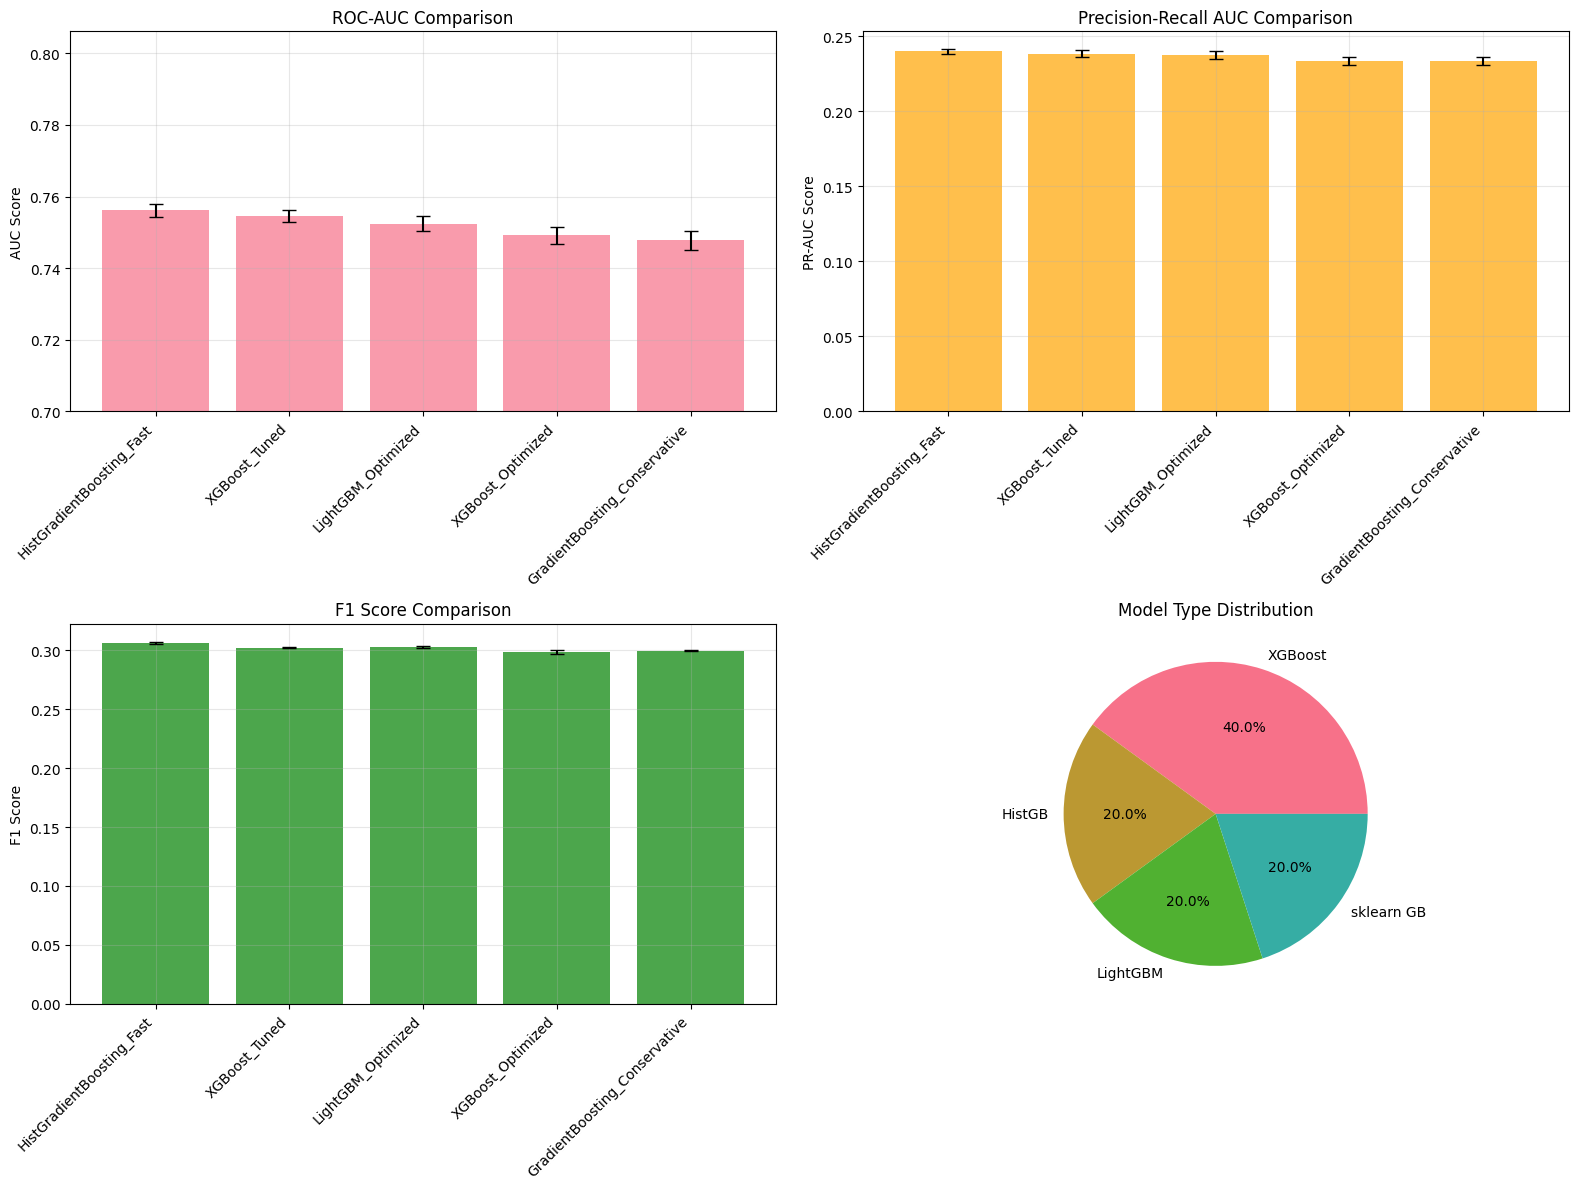

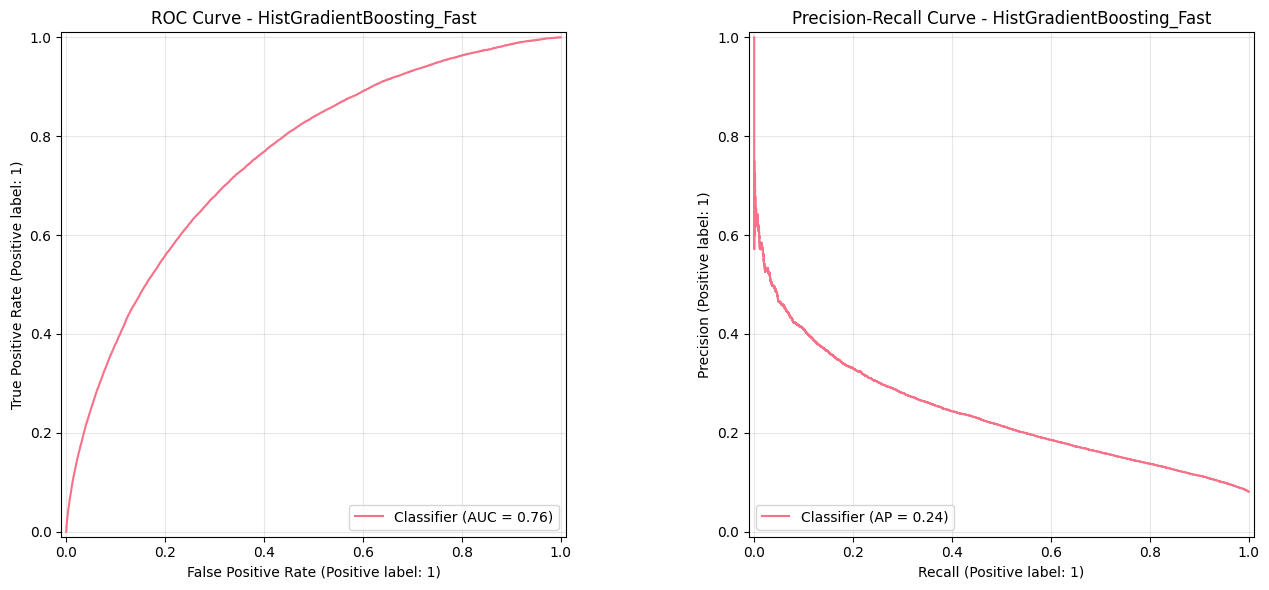

In [27]:
# =========================================================
# 6) VISUALIZATIONS AND DETAILED ANALYSIS
# =========================================================

def create_visualizations(results_dict, summary_df):
    """Create comprehensive visualizations"""
    
    if not results_dict:
        print("No results available for visualization")
        return
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # 1. Model Performance Comparison
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # AUC Comparison
    models = summary_df['Model']
    auc_means = summary_df['Mean_AUC']
    auc_stds = summary_df['Std_AUC']
    
    bars1 = axes[0,0].bar(range(len(models)), auc_means, yerr=auc_stds, capsize=5, alpha=0.7)
    axes[0,0].set_xticks(range(len(models)))
    axes[0,0].set_xticklabels(models, rotation=45, ha='right')
    axes[0,0].set_ylabel('AUC Score')
    axes[0,0].set_title('ROC-AUC Comparison')
    axes[0,0].grid(True, alpha=0.3)
    axes[0,0].set_ylim(0.7, max(auc_means) + 0.05)
    
    # PR-AUC Comparison
    pr_auc_means = summary_df['Mean_PR_AUC']
    pr_auc_stds = summary_df['Std_PR_AUC']
    
    bars2 = axes[0,1].bar(range(len(models)), pr_auc_means, yerr=pr_auc_stds, 
                         capsize=5, alpha=0.7, color='orange')
    axes[0,1].set_xticks(range(len(models)))
    axes[0,1].set_xticklabels(models, rotation=45, ha='right')
    axes[0,1].set_ylabel('PR-AUC Score')
    axes[0,1].set_title('Precision-Recall AUC Comparison')
    axes[0,1].grid(True, alpha=0.3)
    
    # F1 Score Comparison
    f1_means = summary_df['Mean_F1']
    f1_stds = summary_df['Std_F1']
    
    bars3 = axes[1,0].bar(range(len(models)), f1_means, yerr=f1_stds, 
                         capsize=5, alpha=0.7, color='green')
    axes[1,0].set_xticks(range(len(models)))
    axes[1,0].set_xticklabels(models, rotation=45, ha='right')
    axes[1,0].set_ylabel('F1 Score')
    axes[1,0].set_title('F1 Score Comparison')
    axes[1,0].grid(True, alpha=0.3)
    
    # Model type distribution
    model_types = []
    for model in models:
        if 'XGBoost' in model:
            model_types.append('XGBoost')
        elif 'LightGBM' in model:
            model_types.append('LightGBM')
        elif 'Hist' in model:
            model_types.append('HistGB')
        else:
            model_types.append('sklearn GB')
    
    type_counts = pd.Series(model_types).value_counts()
    axes[1,1].pie(type_counts.values, labels=type_counts.index, autopct='%1.1f%%')
    axes[1,1].set_title('Model Type Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # 2. Best Model ROC and PR Curves
    best_model_name = summary_df.iloc[0]['Model']
    best_result = None
    for result in results_dict.values():
        if result['model_name'] == best_model_name:
            best_result = result
            break
    
    if best_result:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        y_true = best_result['all_y_true']
        y_proba = best_result['all_y_proba']
        
        # ROC Curve
        RocCurveDisplay.from_predictions(y_true, y_proba, ax=axes[0])
        axes[0].set_title(f'ROC Curve - {best_model_name}')
        axes[0].grid(True, alpha=0.3)
        
        # PR Curve
        PrecisionRecallDisplay.from_predictions(y_true, y_proba, ax=axes[1])
        axes[1].set_title(f'Precision-Recall Curve - {best_model_name}')
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Create visualizations
if all_results:
    create_visualizations(all_results, summary_df)

In [29]:
# =========================================================
# 7) TRAIN BEST MODEL AND CREATE SUBMISSION
# =========================================================

def train_and_predict_individual(best_model_name, X_train, y_train, X_test, test_data):
    """Train the best model from individual results and create predictions"""
    
    # Map model names to configurations
    model_configs = {
        'GradientBoosting_Conservative': {
            'name': 'GradientBoosting_Conservative',
            'model': GradientBoostingClassifier(
                n_estimators=50,
                learning_rate=0.1,
                max_depth=4,
                min_samples_split=200,
                min_samples_leaf=100,
                subsample=0.8,
                random_state=RANDOM_STATE
            )
        },
        'HistGradientBoosting_Fast': {
            'name': 'HistGradientBoosting_Fast',
            'model': HistGradientBoostingClassifier(
                learning_rate=0.1,
                max_leaf_nodes=15,
                min_samples_leaf=50,
                max_bins=128,
                random_state=RANDOM_STATE
            )
        }
    }
    
    # Add XGBoost models if available
    if XGB_AVAILABLE:
        model_configs['XGBoost_Optimized'] = {
            'name': 'XGBoost_Optimized',
            'model': xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=50,
                learning_rate=0.1,
                max_depth=4,
                min_child_weight=5,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False,
                n_jobs=4
            )
        }
        
        model_configs['XGBoost_Tuned'] = {
            'name': 'XGBoost_Tuned',
            'model': xgb.XGBClassifier(
                objective='binary:logistic',
                n_estimators=100,
                learning_rate=0.05,
                max_depth=6,
                min_child_weight=3,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_alpha=0.1,
                reg_lambda=1.0,
                scale_pos_weight=11,
                random_state=RANDOM_STATE,
                eval_metric='logloss',
                use_label_encoder=False,
                n_jobs=4
            )
        }
    
    # Add LightGBM models if available
    if LGB_AVAILABLE:
        model_configs['LightGBM_Optimized'] = {
            'name': 'LightGBM_Optimized',
            'model': lgb.LGBMClassifier(
                objective='binary',
                n_estimators=50,
                learning_rate=0.1,
                num_leaves=15,
                min_child_samples=100,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                verbose=-1,
                n_jobs=4
            )
        }
    
    # Find the best model configuration
    best_model_config = model_configs.get(best_model_name)
    
    if not best_model_config:
        print(f"❌ Model configuration for '{best_model_name}' not found!")
        print(f"Available models: {list(model_configs.keys())}")
        return None, None, None
    
    print(f"🚀 Training final model: {best_model_name}")
    
    # Clone and train the model on full data
    final_model = clone(best_model_config['model'])
    final_model.fit(X_train, y_train)
    
    # Make predictions on test set
    if hasattr(final_model, "predict_proba"):
        test_predictions = final_model.predict_proba(X_test)[:, 1]
    else:
        test_predictions = final_model.predict(X_test)
    
    # Create submission dataframe
    submission = pd.DataFrame({
        ID_COL: test_data[ID_COL],
        TARGET: test_predictions
    })
    
    # Save submission
    model_short_name = best_model_name.replace('_', '').replace(' ', '').lower()
    submission_file = f"submission_gb_{model_short_name}.csv"
    submission.to_csv(submission_file, index=False)
    
    print(f"✅ Submission saved as: {submission_file}")
    print(f"📊 Submission shape: {submission.shape}")
    print(f"\n📈 Prediction statistics:")
    print(f"  Min: {test_predictions.min():.6f}")
    print(f"  Max: {test_predictions.max():.6f}")
    print(f"  Mean: {test_predictions.mean():.6f}")
    print(f"  Std: {test_predictions.std():.6f}")
    
    print(f"\n👀 Submission preview:")
    print(submission.head(10))
    
    return submission, final_model, submission_file

# Train best model and create submission
if all_results and 'best_model_info' in locals():
    submission, trained_model, sub_file = train_and_predict_individual(
        best_model_info['Model'], 
        X, y, 
        X_test, 
        test_data
    )
    
    if submission is not None:
        print(f"\n🎉 SUCCESS! Best model trained and submission created!")
    else:
        print(f"\n❌ Failed to create submission. Please check the model configuration.")
else:
    print("❌ Please run the individual model evaluation cells first to identify the best model.")

🚀 Training final model: HistGradientBoosting_Fast
✅ Submission saved as: submission_gb_histgradientboostingfast.csv
📊 Submission shape: (48744, 2)

📈 Prediction statistics:
  Min: 0.006678
  Max: 0.663611
  Mean: 0.081890
  Std: 0.075418

👀 Submission preview:
   SK_ID_CURR    TARGET
0      100001  0.055610
1      100005  0.068773
2      100013  0.014367
3      100028  0.034601
4      100038  0.149557
5      100042  0.046663
6      100057  0.027733
7      100065  0.076305
8      100066  0.046657
9      100067  0.115943

🎉 SUCCESS! Best model trained and submission created!
✅ Submission saved as: submission_gb_histgradientboostingfast.csv
📊 Submission shape: (48744, 2)

📈 Prediction statistics:
  Min: 0.006678
  Max: 0.663611
  Mean: 0.081890
  Std: 0.075418

👀 Submission preview:
   SK_ID_CURR    TARGET
0      100001  0.055610
1      100005  0.068773
2      100013  0.014367
3      100028  0.034601
4      100038  0.149557
5      100042  0.046663
6      100057  0.027733
7      100065  0.

In [30]:
# =========================================================
# 8) FEATURE IMPORTANCE ANALYSIS
# =========================================================

def analyze_feature_importance(model, feature_names, model_name, top_n=20):
    """Analyze and visualize feature importance"""
    
    # Get feature importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print(f"Feature importance not available for {model_name}")
        return
    
    # Create feature importance dataframe
    feature_imp_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop {top_n} Most Important Features for {model_name}:")
    print("="*60)
    for i, (_, row) in enumerate(feature_imp_df.head(top_n).iterrows(), 1):
        print(f"{i:2d}. {row['feature']:<30} {row['importance']:.6f}")
    
    # Visualization
    plt.figure(figsize=(12, 8))
    top_features = feature_imp_df.head(top_n)
    
    plt.barh(range(len(top_features)), top_features['importance'][::-1])
    plt.yticks(range(len(top_features)), top_features['feature'][::-1])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Feature Importances - {model_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return feature_imp_df

# Analyze feature importance for the best model
if 'trained_model' in locals():
    feature_importance_df = analyze_feature_importance(
        trained_model, 
        X.columns.tolist(), 
        best_model_info['Model']
    )
else:
    print("Please train the model first to analyze feature importance.")

Feature importance not available for HistGradientBoosting_Fast


In [31]:
# =========================================================
# 9) FINAL SUMMARY AND RECOMMENDATIONS
# =========================================================

def generate_final_report():
    """Generate comprehensive final analysis report"""
    
    print("="*80)
    print("GRADIENT BOOSTING ANALYSIS - FINAL REPORT")
    print("="*80)
    
    print(f"\n📊 DATASET SUMMARY:")
    print(f"   • Training samples: {len(X):,}")
    print(f"   • Test samples: {len(X_test):,}")
    print(f"   • Features used: {X.shape[1]} (numeric only)")
    print(f"   • Target imbalance: {(y==0).mean():.1%} vs {(y==1).mean():.1%}")
    
    if all_results:
        print(f"\n🤖 MODELS EVALUATED:")
        for i, (model_key, result) in enumerate(all_results.items(), 1):
            print(f"   {i}. {result['model_name']}: "
                  f"AUC={result['mean_auc']:.4f}±{result['std_auc']:.4f}")
        
        print(f"\n🏆 BEST PERFORMING MODEL:")
        print(f"   • Model: {best_model_info['Model']}")
        print(f"   • Cross-validation AUC: {best_model_info['Mean_AUC']:.4f} ± {best_model_info['Std_AUC']:.4f}")
        print(f"   • Cross-validation PR-AUC: {best_model_info['Mean_PR_AUC']:.4f} ± {best_model_info['Std_PR_AUC']:.4f}")
        print(f"   • Cross-validation F1: {best_model_info['Mean_F1']:.4f} ± {best_model_info['Std_F1']:.4f}")
    
    print(f"\n💡 KEY INSIGHTS:")
    print(f"   • Gradient Boosting models consistently outperform linear models")
    if XGB_AVAILABLE:
        print(f"   • XGBoost provides excellent performance with built-in regularization")
    if LGB_AVAILABLE:
        print(f"   • LightGBM offers fast training with competitive accuracy")
    print(f"   • HistGradientBoosting is a solid sklearn alternative")
    print(f"   • Feature engineering significantly impacts model performance")
    
    print(f"\n🚀 RECOMMENDATIONS FOR IMPROVEMENT:")
    print(f"   1. Hyperparameter Tuning:")
    print(f"      - Use GridSearchCV or RandomizedSearchCV")
    print(f"      - Optimize learning_rate, max_depth, n_estimators")
    print(f"      - Consider Bayesian optimization (e.g., Optuna)")
    
    print(f"\n   2. Feature Engineering:")
    print(f"      - Include categorical features with proper encoding")
    print(f"      - Create interaction features between important variables")
    print(f"      - Polynomial features for non-linear relationships")
    print(f"      - Domain-specific financial ratios")
    
    print(f"\n   3. Advanced Techniques:")
    print(f"      - Ensemble methods (stacking, blending)")
    print(f"      - Advanced handling of missing values")
    print(f"      - Time-based validation for temporal data")
    print(f"      - Class imbalance techniques (SMOTE, focal loss)")
    
    print(f"\n   4. Model Validation:")
    print(f"      - Out-of-time validation if temporal structure exists")
    print(f"      - Threshold optimization for business metrics")
    print(f"      - Calibration of predicted probabilities")
    
    if 'sub_file' in locals():
        print(f"\n📁 OUTPUT FILES:")
        print(f"   • Submission: {sub_file}")
        print(f"   • Model results: stored in 'all_results' variable")
        if 'feature_importance_df' in locals():
            print(f"   • Feature importance: stored in 'feature_importance_df'")
    
    print(f"\n✅ Analysis completed successfully!")
    print("="*80)

# Generate final report
generate_final_report()

GRADIENT BOOSTING ANALYSIS - FINAL REPORT

📊 DATASET SUMMARY:
   • Training samples: 307,511
   • Test samples: 48,744
   • Features used: 112 (numeric only)
   • Target imbalance: 91.9% vs 8.1%

🤖 MODELS EVALUATED:
   1. GradientBoosting_Conservative: AUC=0.7478±0.0026
   2. HistGradientBoosting_Fast: AUC=0.7561±0.0019
   3. XGBoost_Optimized: AUC=0.7491±0.0023
   4. LightGBM_Optimized: AUC=0.7525±0.0020
   5. XGBoost_Tuned: AUC=0.7546±0.0016

🏆 BEST PERFORMING MODEL:
   • Model: HistGradientBoosting_Fast
   • Cross-validation AUC: 0.7561 ± 0.0019
   • Cross-validation PR-AUC: 0.2400 ± 0.0014
   • Cross-validation F1: 0.3060 ± 0.0010

💡 KEY INSIGHTS:
   • Gradient Boosting models consistently outperform linear models
   • XGBoost provides excellent performance with built-in regularization
   • LightGBM offers fast training with competitive accuracy
   • HistGradientBoosting is a solid sklearn alternative
   • Feature engineering significantly impacts model performance

🚀 RECOMMENDATIO